In [1]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-xago5i9r
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-xago5i9r
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=cc28a113f71e27aa789f790e81d251f9b73b08692ab752844310cbf477af435a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ialt1gxp/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [3]:
from datetime import datetime
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2020-05-30 19:06:32.245885


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
 os.chdir("/content/drive/My Drive/Utils")

In [0]:
from torchvision import transforms
from helper import HelperModel
from dataset_info import DataSetInfo
from dataloader import DataLoader
from models.resnet import ResNet18
from models.QuizDNN import Quiz;
# import model as md
from transforms import Transform
from train import Train
from test import Test
from plot import Plot
from tqdm import tqdm
from albumentation import Albumentation
from gradcam import GradCAM, visualize_cam

### Create model and display summary

In [8]:

model_obj = Quiz()

device = HelperModel.get_device()

model = model_obj.to(device)

#create object for helper with object
helper_obj = HelperModel(model)

#display summaru of model
helper_obj.display_model_summay(model, (3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,456
              ReLU-2          [-1, 128, 32, 32]               0
       BatchNorm2d-3          [-1, 128, 32, 32]             256
           Dropout-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]         147,456
              ReLU-6          [-1, 128, 32, 32]               0
       BatchNorm2d-7          [-1, 128, 32, 32]             256
           Dropout-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]         147,456
             ReLU-10          [-1, 128, 32, 32]               0
      BatchNorm2d-11          [-1, 128, 32, 32]             256
          Dropout-12          [-1, 128, 32, 32]               0
        MaxPool2d-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

### Get data set object

In [0]:
data_set_obj = DataSetInfo("cifa", "./data")

### Get the train test transforms 

In [0]:
import albumentations as A
import albumentations.pytorch as AP

import albumentations as A

means = (0.5, 0.5, 0.5)
stdevs = (0.5, 0.5, 0.5)
customised_transforms =  [ 
                            A.HorizontalFlip(),
                            A.Normalize(mean=means, std=stdevs),
                            A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1),
                            AP.ToTensor() 
                         ]
train_transforms = Albumentation(transforms = customised_transforms)
test_transforms=Albumentation(transforms = [A.Normalize(mean=means, std=stdevs), AP.ToTensor() ])


### Get Train and Test data set

In [11]:
train_set = data_set_obj.get_train_dataset(train_transforms)
test_set = data_set_obj.get_test_dataset(test_transforms)

Files already downloaded and verified
Files already downloaded and verified


### Load the train and test data

In [12]:
data_loader_obj = DataLoader(train_set, test_set, batch_size=128)
train_loader = data_loader_obj.train_loader
test_loader = data_loader_obj.test_loader

CUDA Available? True


### Show some training images

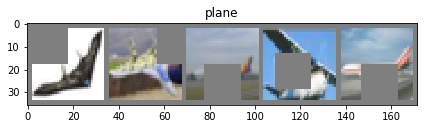

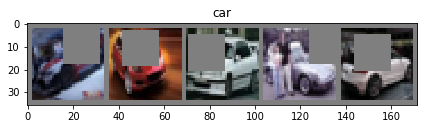

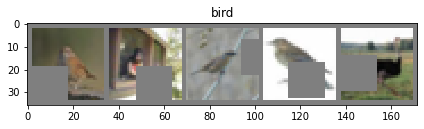

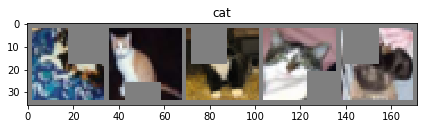

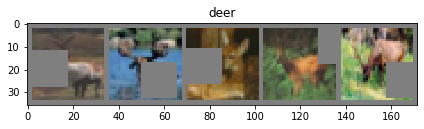

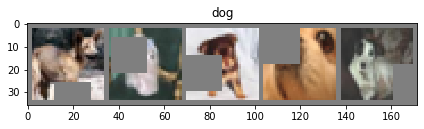

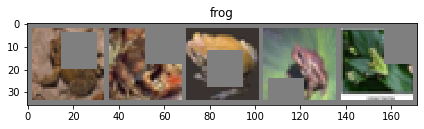

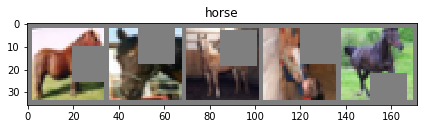

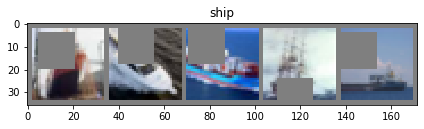

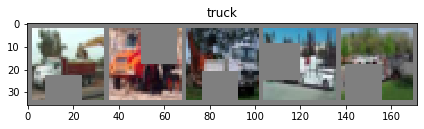

In [13]:
import torchvision
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# show images
Plot.show_cifar_classwise_image(train_loader, classes)


### Run the model

In [14]:
optimizer = helper_obj.get_l2_regularizer(weight_decay=0.0004, lr=0.001, momentum=0.95)
scheduler = helper_obj.get_one_cycle_lr(optimizer=optimizer, lr=0.001)
EPOCHS = 21
l1_factor=0.0001

train_obj = Train()
test_obj = Test()
train_max_acc = []
train_min_loss = []

criterion = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS):

    print("EPOCH:", epoch)
    train_obj.train(model, device, train_loader, optimizer, criterion)
    scheduler.step()
    test_obj.test(model, device, test_loader, criterion, misclassfied_required=True)

    train_max_acc.append(train_obj.train_acc[-1])
    train_min_loss.append(train_obj.train_losses[-1])

misclassified_images = test_obj.misclassified_images
test_losses = test_obj.test_losses
test_acc = test_obj.test_acc
correct_classified_images = test_obj.trueclassified_images
print("Maximum Training Accuracy = ", max(train_max_acc))
print("Maximum Testing Accuracy = ", max(test_acc))




  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Train Set: Train Loss=1.3242900371551514 Batch_id=390 Accuracy=45.65: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Accuracy: 5704/10000 (57.04%)

EPOCH: 2


Train Set: Train Loss=0.9652792811393738 Batch_id=390 Accuracy=59.49: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 6505/10000 (65.05%)

EPOCH: 3


Train Set: Train Loss=0.8528167605400085 Batch_id=390 Accuracy=65.89: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 6572/10000 (65.72%)

EPOCH: 4


Train Set: Train Loss=0.7774632573127747 Batch_id=390 Accuracy=71.18: 100%|██████████| 391/391 [00:28<00:00, 13.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 7074/10000 (70.74%)

EPOCH: 5


Train Set: Train Loss=1.0513460636138916 Batch_id=390 Accuracy=74.55: 100%|██████████| 391/391 [00:28<00:00, 13.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7763/10000 (77.63%)

EPOCH: 6


Train Set: Train Loss=0.6893700361251831 Batch_id=390 Accuracy=76.85: 100%|██████████| 391/391 [00:28<00:00, 13.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7961/10000 (79.61%)

EPOCH: 7


Train Set: Train Loss=0.581253170967102 Batch_id=390 Accuracy=78.24: 100%|██████████| 391/391 [00:28<00:00, 13.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 7728/10000 (77.28%)

EPOCH: 8


Train Set: Train Loss=0.5075862407684326 Batch_id=390 Accuracy=80.02: 100%|██████████| 391/391 [00:28<00:00, 13.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8125/10000 (81.25%)

EPOCH: 9


Train Set: Train Loss=0.4114881455898285 Batch_id=390 Accuracy=80.66: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8297/10000 (82.97%)

EPOCH: 10


Train Set: Train Loss=0.48438388109207153 Batch_id=390 Accuracy=81.55: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8388/10000 (83.88%)

EPOCH: 11


Train Set: Train Loss=0.4182705879211426 Batch_id=390 Accuracy=82.38: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8510/10000 (85.10%)

EPOCH: 12


Train Set: Train Loss=0.6641489267349243 Batch_id=390 Accuracy=83.12: 100%|██████████| 391/391 [00:28<00:00, 13.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8427/10000 (84.27%)

EPOCH: 13


Train Set: Train Loss=0.6351677179336548 Batch_id=390 Accuracy=84.20: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8528/10000 (85.28%)

EPOCH: 14


Train Set: Train Loss=0.3444705307483673 Batch_id=390 Accuracy=84.84: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8605/10000 (86.05%)

EPOCH: 15


Train Set: Train Loss=0.38405317068099976 Batch_id=390 Accuracy=85.96: 100%|██████████| 391/391 [00:28<00:00, 13.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8617/10000 (86.17%)

EPOCH: 16


Train Set: Train Loss=0.5676437616348267 Batch_id=390 Accuracy=87.40: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8824/10000 (88.24%)

EPOCH: 17


Train Set: Train Loss=0.22985386848449707 Batch_id=390 Accuracy=89.04: 100%|██████████| 391/391 [00:28<00:00, 13.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 8922/10000 (89.22%)

EPOCH: 18


Train Set: Train Loss=0.21259090304374695 Batch_id=390 Accuracy=90.15: 100%|██████████| 391/391 [00:28<00:00, 13.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9019/10000 (90.19%)

EPOCH: 19


Train Set: Train Loss=0.29997044801712036 Batch_id=390 Accuracy=91.30: 100%|██████████| 391/391 [00:28<00:00, 13.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9062/10000 (90.62%)

EPOCH: 20


Train Set: Train Loss=0.37168601155281067 Batch_id=390 Accuracy=91.58: 100%|██████████| 391/391 [00:28<00:00, 13.65it/s]



Test set: Average loss: 0.0022, Accuracy: 9066/10000 (90.66%)

Maximum Training Accuracy =  91.58
Maximum Testing Accuracy =  90.66


### Display graphs

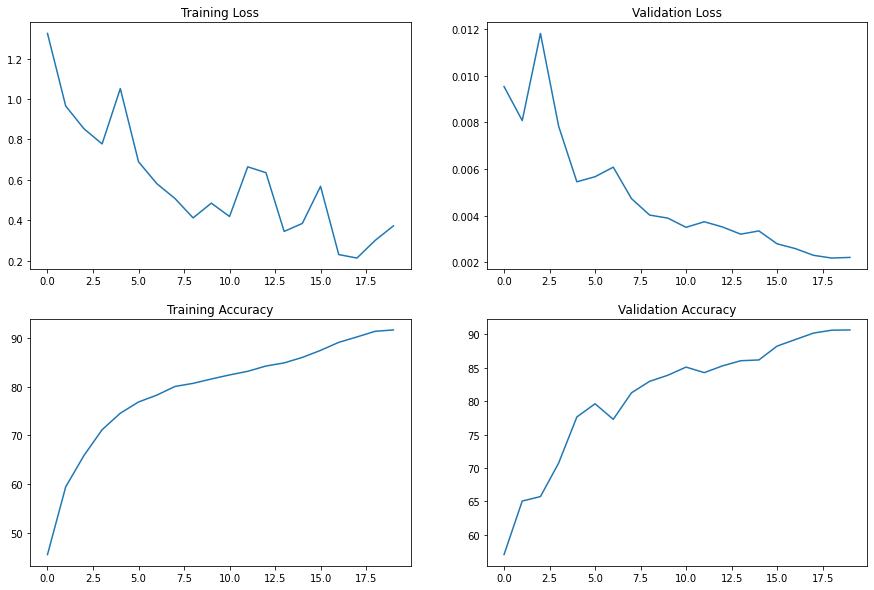

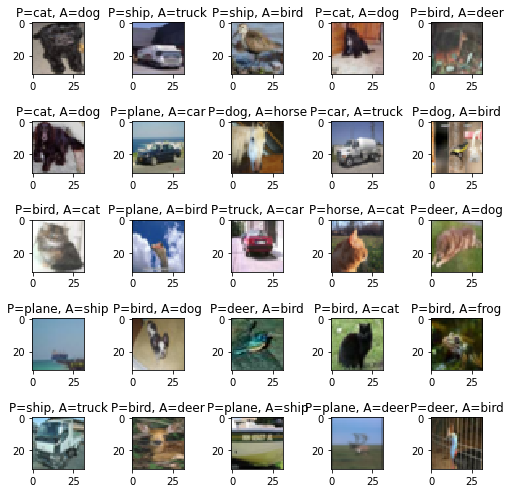

In [15]:
plt_obj = Plot(train_max_acc, train_min_loss, test_acc, test_losses)
plt_obj.display_all_plot()
plt_obj.plot_cifar_misclassified(misclassified_images)